In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
train_range = 150
test_range = 50

In [3]:
class CSVDataset(torch.utils.data.Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        xy = np.loadtxt('/content/gdrive/MyDrive/Colab Notebooks/양자 해커톤/dataset/caesar_int8_train.csv',
                        delimiter=',', dtype=np.float32)
        self.len = train_range

        self.x_data = torch.from_numpy(xy[:train_range, 1:17])
        self.y_data = torch.from_numpy(xy[:train_range, 0])
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = CSVDataset()
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=8,
                          shuffle=False,
                            drop_last = True)


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.input = nn.Linear(16, 64)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        x = torch.sigmoid(x)

        return x 


In [5]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCELoss()


epochs = 20
loss_list = []
model.train()

ts = time.time()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, x in enumerate(train_loader):
        data, target = x
        target = target.unsqueeze(1)
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)

        # Calculating loss
        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()


        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

te = time.time()

print("runtime: ", te-ts)

Training [5%]	Loss: 0.6933
Training [10%]	Loss: 0.6834
Training [15%]	Loss: 0.6783
Training [20%]	Loss: 0.6713
Training [25%]	Loss: 0.6636
Training [30%]	Loss: 0.6532
Training [35%]	Loss: 0.6374
Training [40%]	Loss: 0.6255
Training [45%]	Loss: 0.5957
Training [50%]	Loss: 0.5887
Training [55%]	Loss: 0.5731
Training [60%]	Loss: 0.5393
Training [65%]	Loss: 0.5503
Training [70%]	Loss: 0.5222
Training [75%]	Loss: 0.4929
Training [80%]	Loss: 0.4633
Training [85%]	Loss: 0.4528
Training [90%]	Loss: 0.4415
Training [95%]	Loss: 0.4007
Training [100%]	Loss: 0.3854
runtime:  0.5905900001525879


Text(0, 0.5, 'Neg Log Likelihood Loss')

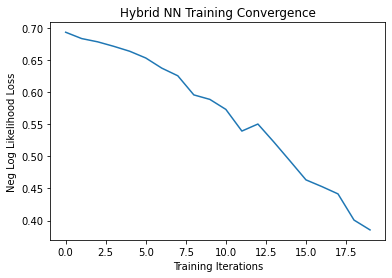

In [6]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [7]:
class CSVDataset(torch.utils.data.Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        xy = np.loadtxt('/content/gdrive/MyDrive/Colab Notebooks/양자 해커톤/dataset/caesar_int8_test.csv',
                        delimiter=',', dtype=np.float32)
        self.len = test_range
        self.x_data = torch.from_numpy(xy[:test_range, 1:17])
        self.y_data = torch.from_numpy(xy[:test_range, 0])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = CSVDataset()
test_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=8,
                          shuffle=False,
                            drop_last=True)

In [8]:
import math
model.eval()
with torch.no_grad():
    
    correct = 0

    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        pred = output
        target = target.unsqueeze(1)
        
        for i in range(8):
            if (output[i] > 0.5):
                pred[i] = math.ceil(output[i])
            else:
                pred[i] = math.floor(output[i])

        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = loss_func(output, target)
        total_loss.append(loss.item())
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(dataset) * 100)
        )

Performance on test data:
	Loss: 9.6640
	Accuracy: 60.0%
